In [1]:
# !conda install -c conda-forge tqdm -n TORCH_ENV_NAME
# !pip install torchinfo

import os
import sys
sys.path.append('lib')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import utils
import hyperparameter as hp
from stock_data import stock_data
from RNN import RNN

# Pre-training

## Set hyper parameters

STOCKS: name of stocks to be predicted -> Choose from data


PRECISON: precision of prediction -> 32/64


PRE_PROCESS: Whether to use pre-processed data from data_preprocessing.ipynb -> True/False


RNN_TYPE: type of rnn -> (bi)RNN, (bi)LSTM, (bi)GRU


IN_FEATURES/OUT_FEATURES: features to be input/output of machine -> Open, Close, High, Low


SCALER_NAME: Name of sklearn.preprocessing scaler -> MinMaxScaler, StandardScaler, RobustScaler,...


HIDDEN_SIZE: Size of hidden variables inside RNN/LSTM/GRU module


NUM_LAYERS: Number of stacked layers of RNN/LSTM/GRU module


DROPOUT: drop out rate of NN


PAST_DAYS: Number of days to be used to predict


SUCCESSIVE_DAYS: Number of days to be predicted


OPTIMIZER_NAME: Name of optimizer to be used -> RMSprop, Adam, Adagrad, ...


LEARNING_RATE: learning rate of optimizer


L2_REGULARIZATION: L2 regularization factor for optimizer


LOSS_NAME: Name of loss function -> MSELoss, SmoothL1Loss, ...


SCALER_NAME: name of scaler to normalize data -> 'MinMaxScaler'



In [2]:
#* Set hyper parameter and prefix
param = hp.set_default()
param.successive_days=5
PREFIX = hp.generate_prefix(param)

#* Red param from prefix
# PREFIX = 'AMZN_32_RNN_OHLC2HL_HS200_NL3_DO0.10_PD80_SD5_LR0.0005_RG1e-05_LFSmoothL1Loss'
# param = hp.read_prefix(PREFIX)

#* Set device
print("Using device: {}".format(param.device))

#* Set overall precision
torch.set_default_dtype(getattr(torch, 'float' + param.precision))

#* prefix
print(PREFIX)

Using device: cuda:0
AMZN_32_GRU_HL2HL_PD30_SD5_Standard_NL1_HL150_DO0.2_BN0_Adam_LR0.005_RG0.05_MSELoss


## Generate dataset

In [3]:
data = stock_data(param=param,
                  pre_process=True,
                  use_dataset=True,
                  verbose=True)

Finished reading a file data/pre_32/AMZN.parquet.snappy
-----------------------------
Number of train set: 1978 with input: torch.Size([30, 2]) output: torch.Size([5, 2])
Number of validation set: 500 with input: torch.Size([30, 2]) output: torch.Size([5, 2])
Number of test set: 499 with input: torch.Size([30, 2]) output: torch.Size([5, 2])


## Define neural network, loss function, optimizer type

In [7]:
#* Define model
model = RNN(param=param).to(param.device)

#* optimizer, loss function
optimizer = getattr(optim, param.optimizer_name)(params=model.parameters(),
                                                 lr=param.learning_rate,
                                                 weight_decay=param.L2)
loss_func = getattr(nn, param.loss_name)(reduction='sum').to(param.device)

#* Initialize epoch, loss list
epoch, min_val_loss = 0, np.Inf
train_loss_list, val_loss_list = np.array([]), np.array([])

#* Summarize the model
example_input, example_output = data.train_dataset[0]
utils.model_summary(model, input_size=example_input.shape, precision=param.precision)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
RNN                                      --               --               --               --               --
├─rnn.weight_ih_l0                                                         [450, 2]
├─rnn.weight_hh_l0                                                         [450, 150]
├─out_layer.1.weight                                                       [2, 150]
├─GRU: 1-1                               [1, 30, 2]       [1, 30, 150]     --               69,300           2,079,000
│    └─weight_ih_l0                                                        [450, 2]
│    └─weight_hh_l0                                                        [450, 150]
├─Sequential: 1-2                        [1, 150]         [1, 2]           --               --               --
│    └─1.weight                                                            [2, 150]
│    └─Dropout: 2-1           

## Benchmark
Do not run benchmark unless you re-run the above cell: This will change your model parameter


In [5]:
utils.benchmark(model=model,
                data=data,
                loss_func=loss_func,
                optimizer=optimizer,
                param=param,
                save_path=os.path.join("profile", PREFIX))

## Load model if needed

In [11]:
#* Load model with prefix
epoch = 94

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)),
                        map_location=param.device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
min_val_loss = val_loss_list[-1]
test_mse = checkpoint['test_mse']
print("Loaded model has average test MSE: {:.6f}".format(test_mse))

try:
    print("REMARK:", checkpoint['Remark'])
except KeyError:
    pass


Loaded model has average test MSE: 0.638882
REMARK: Early stopped


# Training

In [8]:
train_loss, val_loss, best = utils.train(model=model,
                                         data=data,
                                         max_epoch=100,
                                         loss_func=loss_func,
                                         optimizer=optimizer,
                                         param=param,
                                         min_val_loss=min_val_loss,
                                         verbose=1)

#* Load best model state and epoch number
if best[0] is None:     # Only when loaded model and newly trained is already overfitted
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(best[0])
best_epoch = best[1]

#* Update epoch and loss lists, accuracy lists
epoch += best_epoch + 1
train_loss_list = np.concatenate((train_loss_list,
                                  train_loss[:best_epoch + 1 + param.early_stop_patience]))
val_loss_list = np.concatenate((val_loss_list,
                                val_loss[:best_epoch + 1 + param.early_stop_patience]))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1	Validation loss decreased (inf --> 0.491113). Saving model
Epoch 2	Early Stopping counter: 1/10
Epoch 3	Early Stopping counter: 2/10
Epoch 4	Early Stopping counter: 3/10
Epoch 5	Validation loss decreased (0.491113 --> 0.461655). Saving model
Epoch 6	Early Stopping counter: 1/10
Epoch 7	Validation loss decreased (0.461655 --> 0.284060). Saving model
Epoch 8	Validation loss decreased (0.284060 --> 0.264632). Saving model
Epoch 9	Early Stopping counter: 1/10
Epoch 10	Early Stopping counter: 2/10
Epoch 11	Validation loss decreased (0.264632 --> 0.244427). Saving model
Epoch 12	Validation loss decreased (0.244427 --> 0.228056). Saving model
Epoch 13	Early Stopping counter: 1/10
Epoch 14	Early Stopping counter: 2/10
Epoch 15	Validation loss decreased (0.228056 --> 0.223187). Saving model
Epoch 16	Early Stopping counter: 1/10
Epoch 17	Early Stopping counter: 2/10
Epoch 18	Validation loss decreased (0.223187 --> 0.219519). Saving model
Epoch 19	Validation loss decreased (0.219519 --> 0

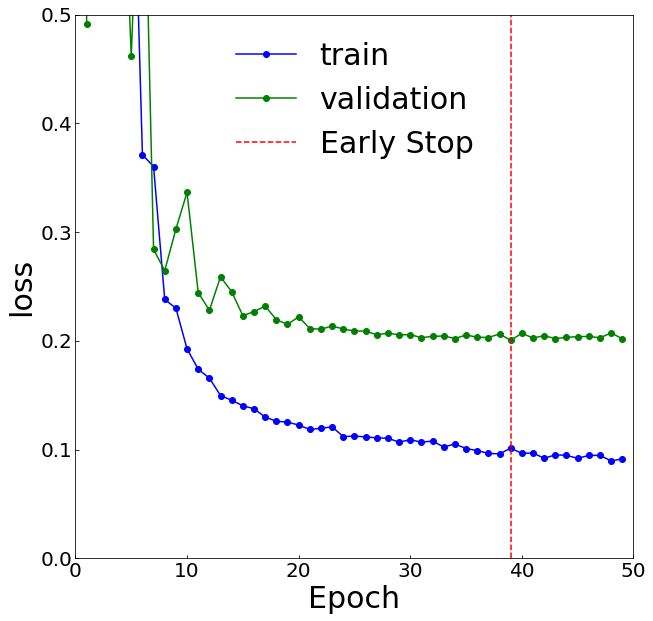

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
utils.plot_loss(train_loss_list=train_loss_list,
                val_loss_list=val_loss_list,
                stop_epoch=epoch,
                ax=ax)
ax.set_ylim([0, 0.5])
# fig.savefig(os.path.join("fig", 'loss_' + PREFIX + '.png'))


# Test

Average test finished with 0.70 seconds with MSE 0.530005


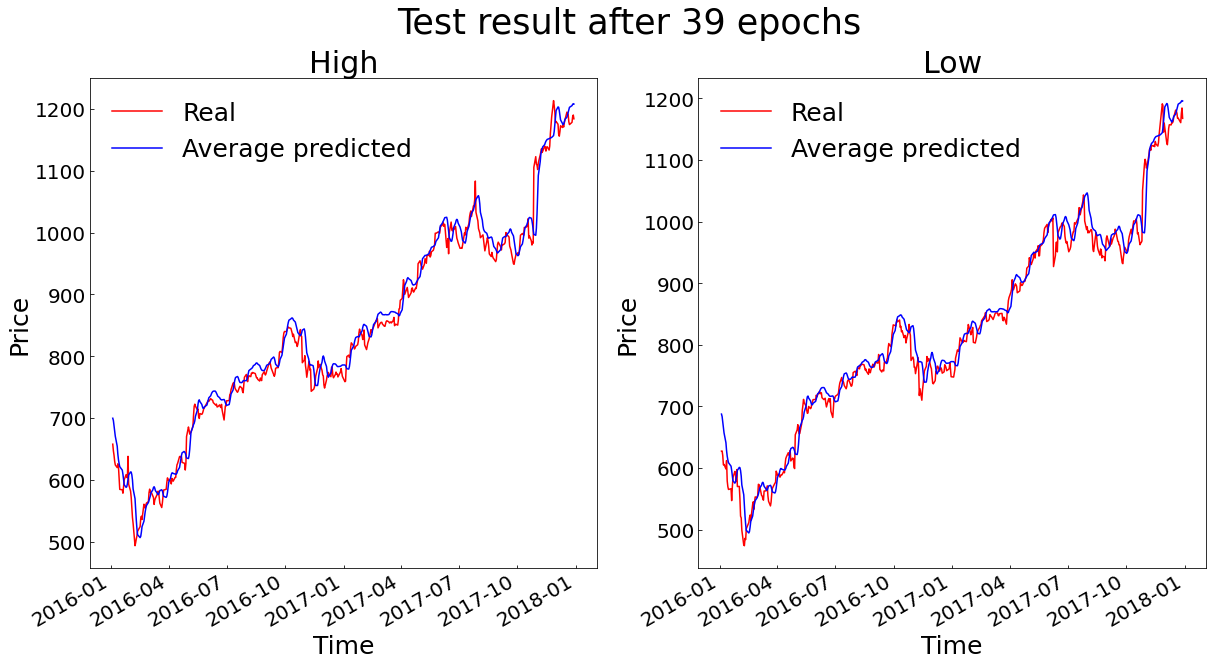

In [12]:
avg_prediction, avg_test_mse = utils.average_test(model, data, verbose=True)

ax = utils.plot_prediction(data=data,
                           epoch=epoch,
                           avg_prediction=avg_prediction,
                        #    save_path=os.path.join('fig', 'prdiction_' + PREFIX + ".png")
                           )


# Save the model

In [13]:
#* Save the model with current state
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list[:epoch],
            'val_loss_list': val_loss_list[:epoch],
            'Remark': 'Early stopped',
            'test_mse': avg_test_mse
            },
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch)))

print("Saved model", PREFIX + '_{}.pth'.format(epoch))

Saved model AMZN_32_GRU_HL2HL_PD30_SD5_Standard_NL1_HL150_DO0.2_BN0_Adam_LR0.005_RG0.05_MSELoss_39.pth


# Find best model

In [18]:
best_MSE = np.Inf
for file in os.listdir('model'):
    if 'AMZN' in file and 'SD{}_'.format(param.successive_days) in file:
        checkpoint = torch.load(os.path.join('model', file))
        try:
            test_mse = checkpoint['test_mse']
            if test_mse < best_MSE:
                best_name = file
                best_MSE = test_mse
        except (KeyError, TypeError, ValueError):
            continue
print(best_name, best_MSE)

AMZN_32_GRU_HL2HL_PD30_SD5_Standard_NL1_HL150_DO0.2_BN0_Adam_LR0.005_RG0.05_MSELoss_39.pth 0.530004841285876
